# <center style='color:deeppink'>Vector-Quantized Variational AutoEncoder (`VQ-VAE`) using PyTorch - Example with `MNIST` dataset</center>

# 1. Import required libraries

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchinfo import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.0.1+cu117 

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Load `MNIST` dataset

In [3]:
training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transforms.ToTensor())

100%|██████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 102270731.13it/s]


Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw



100%|██████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 223085992.31it/s]


Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



100%|███████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 69327379.50it/s]

Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw


100%|█████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 14432218.76it/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



In [4]:
print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 60000
Length of the test dataset: 10000


In [5]:
print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: torch.Size([60000, 28, 28])
Shape of the test dataset: torch.Size([10000, 28, 28])


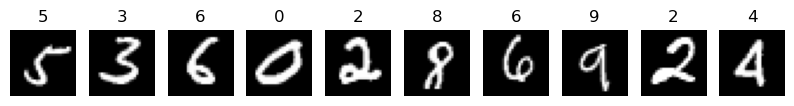

In [6]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

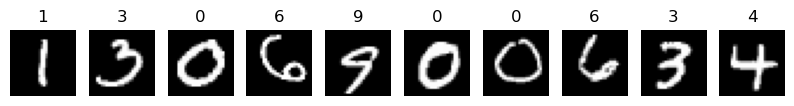

In [7]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

# 4. Define dataloaders

In [8]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [9]:
print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 937
Length of the test dataloader: 156


- create `ENCODER` class

In [10]:
class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor1', nn.BatchNorm2d(num_features=16))
        self.encoder.add_module('relu1', nn.ReLU(inplace=True))
        self.encoder.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor2', nn.BatchNorm2d(num_features=32))
        self.encoder.add_module('relu2', nn.ReLU(inplace=True))
        self.encoder.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
        
    def forward(self, x):
        enc_out = self.encoder(x)
        return enc_out

- visualize `ENCODER` class

In [11]:
summary(ENCODER(), input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ENCODER                                  [64, 64, 7, 7]            --
├─Sequential: 1-1                        [64, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 14, 14]          272
│    └─BatchNorm2d: 2-2                  [64, 16, 14, 14]          32
│    └─ReLU: 2-3                         [64, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [64, 32, 7, 7]            8,224
│    └─BatchNorm2d: 2-5                  [64, 32, 7, 7]            64
│    └─ReLU: 2-6                         [64, 32, 7, 7]            --
│    └─Conv2d: 2-7                       [64, 64, 7, 7]            18,496
Total params: 27,088
Trainable params: 27,088
Non-trainable params: 0
Total mult-adds (M): 87.21
Input size (MB): 0.20
Forward/backward pass size (MB): 6.42
Params size (MB): 0.11
Estimated Total Size (MB): 6.73

- create `VQ` class

In [12]:
class VQ(nn.Module):
    def __init__(self):
        super(VQ, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=256, embedding_dim=64)
        self.commitment_cost = 0.25
        
    def forward(self, x):
        
        B, C, H, W = x.shape # shape -> B, C, H, W
        x = x.permute(0, 2, 3, 1) # shape -> B, H, W, C
        x = x.reshape(x.shape[0], -1, x.shape[3]) # shape -> B, H*W, C
        
        distances = torch.cdist(x, self.embedding.weight[None, :].repeat((x.shape[0], 1, 1))) # shape -> B, H*W, NE
        encoding_indices = torch.argmin(distances, dim=-1) # shape -> B, H*W
        
        quantized = torch.index_select(self.embedding.weight, dim=0, index=encoding_indices.view(-1)) # shape -> B*H*W, ED
        x = x.reshape((-1, x.shape[2])) # shape -> B*H*W, C

        commitment_loss = torch.mean((quantized.detach() - x) ** 2)
        codebook_loss = torch.mean((quantized - x.detach()) ** 2)
        loss = codebook_loss + self.commitment_cost * commitment_loss
        
        # straight through estimator
        quantized = x + (quantized - x).detach() # shape -> B*H*W, ED=C
        quantized = quantized.reshape((B, H, W, C)).permute(0, 3, 1, 2) # shape -> B, C, H, W
        codebook_indices = encoding_indices.reshape((-1, quantized.shape[2], quantized.shape[3])) # shape -> B, H, W
        
        return quantized, loss, codebook_indices

In [13]:
summary(VQ(), input_size=(64, 64, 7, 7))

Layer (type:depth-idx)                   Output Shape              Param #
VQ                                       [64, 64, 7, 7]            16,384
Total params: 16,384
Trainable params: 16,384
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.80
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.80

- create `DECODER` class

In [14]:
class DECODER(nn.Module):
    def __init__(self):
        super(DECODER, self).__init__()
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('tcon3', nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1,
                                                            padding=1))
        self.decoder.add_module('bnor3', nn.BatchNorm2d(num_features=32))
        self.decoder.add_module('relu3', nn.ReLU(inplace=True))
        self.decoder.add_module('tcon2', nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2,
                                                            padding=1))
        self.decoder.add_module('bnor2', nn.BatchNorm2d(num_features=16))
        self.decoder.add_module('relu2', nn.ReLU(inplace=True))
        self.decoder.add_module('tcon1', nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2,
                                                            padding=1))
        self.decoder.add_module('sgmd1', nn.Sigmoid())
        
    def forward(self, x):
        out = self.decoder(x)
        return out

- visualize `DECODER` class

In [15]:
summary(DECODER(), input_size=(64, 64, 7, 7))

Layer (type:depth-idx)                   Output Shape              Param #
DECODER                                  [64, 1, 28, 28]           --
├─Sequential: 1-1                        [64, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-1              [64, 32, 7, 7]            18,464
│    └─BatchNorm2d: 2-2                  [64, 32, 7, 7]            64
│    └─ReLU: 2-3                         [64, 32, 7, 7]            --
│    └─ConvTranspose2d: 2-4              [64, 16, 14, 14]          8,208
│    └─BatchNorm2d: 2-5                  [64, 16, 14, 14]          32
│    └─ReLU: 2-6                         [64, 16, 14, 14]          --
│    └─ConvTranspose2d: 2-7              [64, 1, 28, 28]           257
│    └─Sigmoid: 2-8                      [64, 1, 28, 28]           --
Total params: 27,025
Trainable params: 27,025
Non-trainable params: 0
Total mult-adds (M): 173.77
Input size (MB): 0.80
Forward/backward pass size (MB): 5.22
Params size (MB): 0.11
Estimated Total Size (MB): 6.13

# 5. Define `VQVAE` architecture

In [16]:
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        
        self.encoder = ENCODER()
        self.vq = VQ()
        self.decoder = DECODER()
        
    def forward(self, x):
        enc_out = self.encoder(x)
        quant_out, quant_loss, _ = self.vq(enc_out)
        out = self.decoder(quant_out)
        return out, quant_loss

# 6. Visualize `VQVAE` architecture

In [17]:
summary(VQVAE(), input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [64, 1, 28, 28]           --
├─ENCODER: 1-1                           [64, 64, 7, 7]            --
│    └─Sequential: 2-1                   [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-1                  [64, 16, 14, 14]          272
│    │    └─BatchNorm2d: 3-2             [64, 16, 14, 14]          32
│    │    └─ReLU: 3-3                    [64, 16, 14, 14]          --
│    │    └─Conv2d: 3-4                  [64, 32, 7, 7]            8,224
│    │    └─BatchNorm2d: 3-5             [64, 32, 7, 7]            64
│    │    └─ReLU: 3-6                    [64, 32, 7, 7]            --
│    │    └─Conv2d: 3-7                  [64, 64, 7, 7]            18,496
├─VQ: 1-2                                [64, 64, 7, 7]            16,384
├─DECODER: 1-3                           [64, 1, 28, 28]           --
│    └─Sequential: 2-2                   [64, 1, 28, 28]           --
│  

# 7. Define the training batch

In [18]:
def training_batch(data, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    output, quantize_loss = model(data)
    recon_loss = criterion(output, data)
    loss = recon_loss + quantize_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

# 8. Define the test batch

In [19]:
with torch.inference_mode():
    def test_batch(data, model, criterion):
        model.eval()
        data = data.to(device)
        output, quantize_loss = model(data)
        recon_loss = criterion(output, data)
        loss = recon_loss + quantize_loss
        return loss

# 9. Set up model (`VQVAE`), criterion (`loss function`) and optimizer

In [20]:
model = VQVAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 10. Train the model

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

n_epochs = 15
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        trng_batch_loss = training_batch(data, model, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    for data, _ in tqdm(test_dataloader):
        tst_batch_loss = test_batch(data, model, criterion)
        test_losses.append(tst_batch_loss.item())
    test_per_epoch_loss = np.array(test_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |    ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 247.79it/s]


Epoch: 1/15	| Training loss: 0.1594 |    Test loss: 0.0904


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 246.04it/s]


Epoch: 2/15	| Training loss: 0.0873 |    Test loss: 0.0864


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 248.13it/s]


Epoch: 3/15	| Training loss: 0.0810 |    Test loss: 0.0805


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 243.74it/s]


Epoch: 4/15	| Training loss: 0.0758 |    Test loss: 0.0744


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 246.73it/s]


Epoch: 5/15	| Training loss: 0.0732 |    Test loss: 0.0702


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 244.55it/s]


Epoch: 6/15	| Training loss: 0.0713 |    Test loss: 0.0700


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 244.75it/s]


Epoch: 7/15	| Training loss: 0.0701 |    Test loss: 0.0692


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 248.51it/s]


Epoch: 8/15	| Training loss: 0.0693 |    Test loss: 0.0677


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 245.67it/s]


Epoch: 9/15	| Training loss: 0.0684 |    Test loss: 0.0679


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 250.04it/s]


Epoch: 10/15	| Training loss: 0.0674 |    Test loss: 0.0655


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 245.53it/s]


Epoch: 11/15	| Training loss: 0.0669 |    Test loss: 0.0666


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 249.86it/s]


Epoch: 12/15	| Training loss: 0.0664 |    Test loss: 0.0674


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 245.04it/s]


Epoch: 13/15	| Training loss: 0.0664 |    Test loss: 0.0670


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 246.83it/s]


Epoch: 14/15	| Training loss: 0.0663 |    Test loss: 0.0662


100%|████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 246.55it/s]

Epoch: 15/15	| Training loss: 0.0663 |    Test loss: 0.0654


# 11. Plot model loss

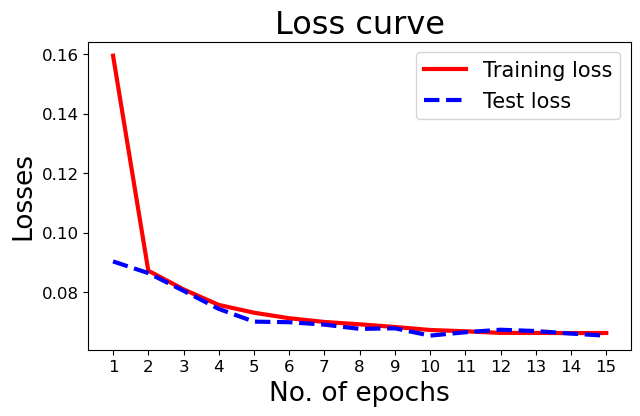

In [22]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(7, 4))
plt.plot(N, training_loss, 'r-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b--', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Losses', fontsize=19)
plt.xticks(N, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15);

# 12. Model prediction

In [23]:
random_indices = torch.randint(0, len(test_dataset), (25,))
select_random_samples = torch.cat([test_dataset[i][0][None, :] for i in random_indices])
select_random_samples = select_random_samples.to(device)

model.eval()
reconstructed, _ = model(select_random_samples)

org_grid = make_grid(select_random_samples.detach().cpu(), nrow=5)
rec_grid = make_grid(reconstructed.detach().cpu(), nrow=5)

_, _, codebook_learned = model.vq(model.encoder(select_random_samples))
codebook = codebook_learned.unsqueeze(1)
codebook_grid = make_grid(codebook.detach().cpu(), nrow=5)

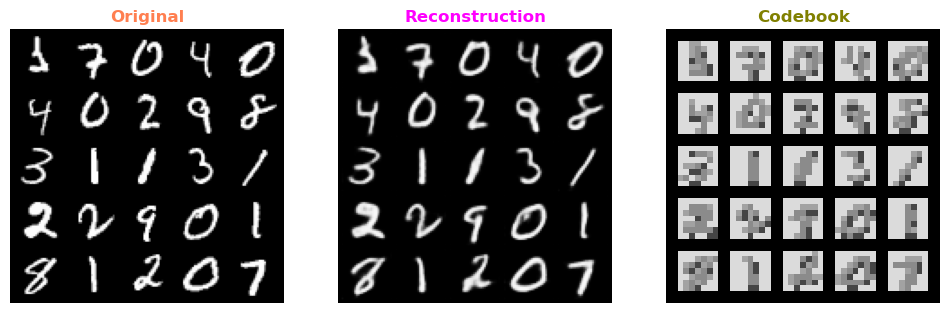

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(org_grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Original', fontweight='bold', color='coral')
plt.subplot(1, 3, 2)
plt.imshow(rec_grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Reconstruction', fontweight='bold', color='magenta')
plt.subplot(1, 3, 3)
plt.imshow(codebook_grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Codebook', fontweight='bold', color='olive');